In [210]:
!pip install POT

C:\Apps\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


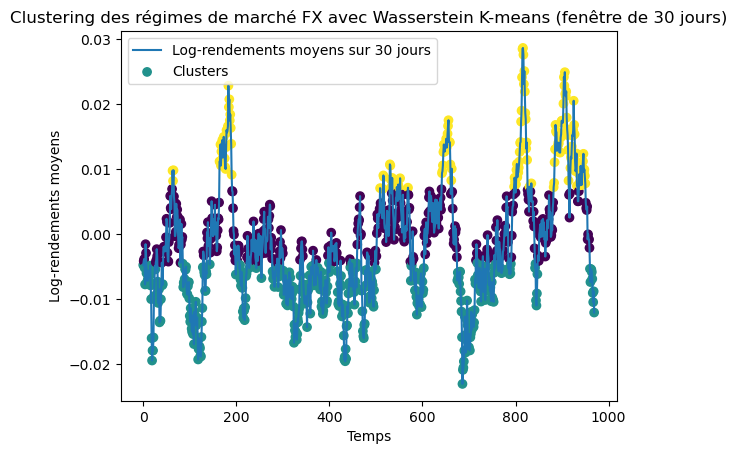

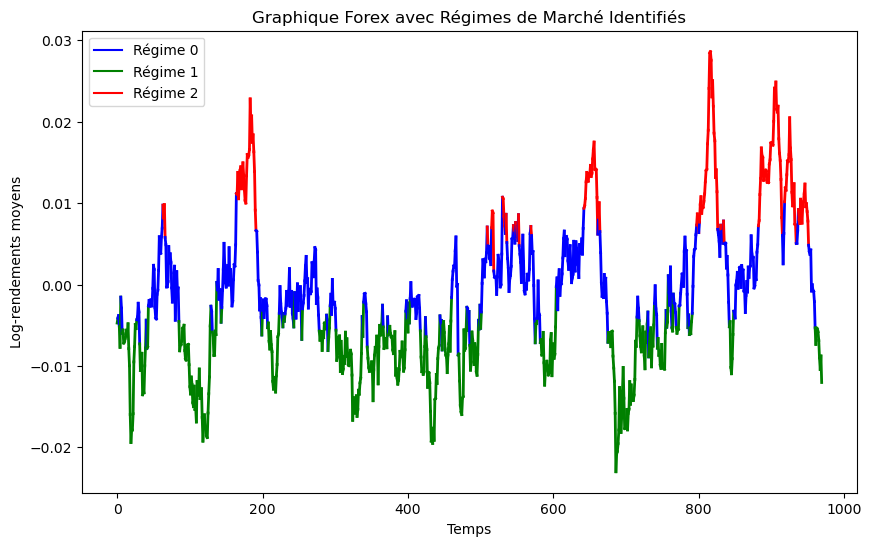

In [211]:
# Importation des bibliothèques nécessaires
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.cluster import KMeans
from ot import emd2  # Pour le calcul de la distance de Wasserstein
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Chargement des données et calcul des log-rendements sur une fenêtre de 30 jours
def load_data(window=30):
    prix_fx = np.random.normal(1, 0.05, 1000).cumprod()  # Génère une série de prix
    log_returns = np.diff(np.log(prix_fx))  # Calcul des log-rendements instantanés

    # Calcul des log-rendements moyens sur des fenêtres de 30 jours
    windowed_log_returns = np.array([
        np.mean(log_returns[i:i+window]) for i in range(len(log_returns) - window + 1)
    ])

    return prix_fx,windowed_log_returns

# Chargement des données et calcul des log-rendements instantanés (1 jour)
#def load_data():
#    prix_fx = np.random.normal(1, 0.05, 1000).cumprod()  # Génère une série de prix
#    log_returns = np.diff(np.log(prix_fx))  # Calcul des log-rendements instantanés (1 jour)
#    return log_returns

# Fonction de calcul de la distance de Wasserstein entre distributions de log-rendements
def wasserstein_distance_matrix(data):
    n = len(data)
    W_distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            W_distances[i, j] = emd2(data[i].reshape(-1, 1), data[j].reshape(-1, 1))
            W_distances[j, i] = W_distances[i, j]
    return W_distances

# Implémentation de l'algorithme Wasserstein K-means
class WassersteinKMeans:
    def __init__(self, n_clusters, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def fit(self, data):
        # Initialisation des clusters avec KMeans classique pour obtenir les premiers centroids
        kmeans = KMeans(n_clusters=self.n_clusters)
        labels = kmeans.fit_predict(data)
        self.centroids = [self.compute_wasserstein_barycenter(data[labels == k]) for k in range(self.n_clusters)]

        for iteration in range(self.max_iter):
            # Calcul des barycentres Wasserstein pour chaque cluster
            new_centroids = []
            for k in range(self.n_clusters):
                cluster_points = data[labels == k]
                if len(cluster_points) > 0:
                    centroid = self.compute_wasserstein_barycenter(cluster_points)
                    new_centroids.append(centroid)
                else:
                    new_centroids.append(self.centroids[k])  # Garde l'ancien centre si le cluster est vide

            new_centroids = np.array(new_centroids)

            # Vérification de la convergence
            shift = np.sum([wasserstein_distance(self.centroids[i], new_centroids[i]) for i in range(self.n_clusters)])
            if shift < self.tol:
                break
            self.centroids = new_centroids
            # Réassignation des labels en fonction des nouvelles distances Wasserstein
            labels = np.array([np.argmin([wasserstein_distance(data[i], self.centroids[j]) for j in range(self.n_clusters)]) for i in range(len(data))])

        return labels

    def compute_wasserstein_barycenter(self, distributions):
        # Fonction simplifiée pour le barycentre Wasserstein
        return np.mean(distributions, axis=0)

# Exécution de l'algorithme avec la série de log-rendements moyennés
prix,log_returns = load_data(window=30)
wasserstein_kmeans = WassersteinKMeans(n_clusters=3)
labels = wasserstein_kmeans.fit(log_returns.reshape(-1, 1))

# Visualisation des résultats sous forme de points
plt.plot(log_returns, label="Log-rendements moyens sur 30 jours")
plt.scatter(range(len(log_returns)), log_returns, c=labels, cmap='viridis', label="Clusters")
plt.xlabel("Temps")
plt.ylabel("Log-rendements moyens")
plt.title("Clustering des régimes de marché FX avec Wasserstein K-means (fenêtre de 30 jours)")
plt.legend()
plt.show()

#On regarde ici les résultats sous forme de segments colorés
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']  # Définir les couleurs pour les clusters

for i in range(len(log_returns) - 1):
    plt.plot(
        [i, i + 1],
        [log_returns[i], log_returns[i + 1]],
        color=colors[labels[i]],
        linewidth=2
    )

plt.xlabel("Temps")
plt.ylabel("Log-rendements moyens")
plt.title("Graphique Forex avec Régimes de Marché Identifiés")
for i, color in enumerate(colors):
    plt.plot([], [], color=color, label=f"Régime {i}")
plt.legend()
plt.show()

# Exécution de l'algorithme avec la série de log-rendements journaliers
#log_returns = load_data()
#wasserstein_kmeans = WassersteinKMeans(n_clusters=3)
#labels = wasserstein_kmeans.fit(log_returns.reshape(-1, 1))

# Visualisation des résultats
#plt.plot(log_returns, label="Log-rendements journaliers")
#plt.scatter(range(len(log_returns)), log_returns, c=labels, cmap='viridis', label="Clusters")
#plt.xlabel("Temps")
#plt.ylabel("Log-rendements")
#plt.title("Clustering des régimes de marché FX avec Wasserstein K-means (1 jour)")
#plt.legend()
#plt.show()

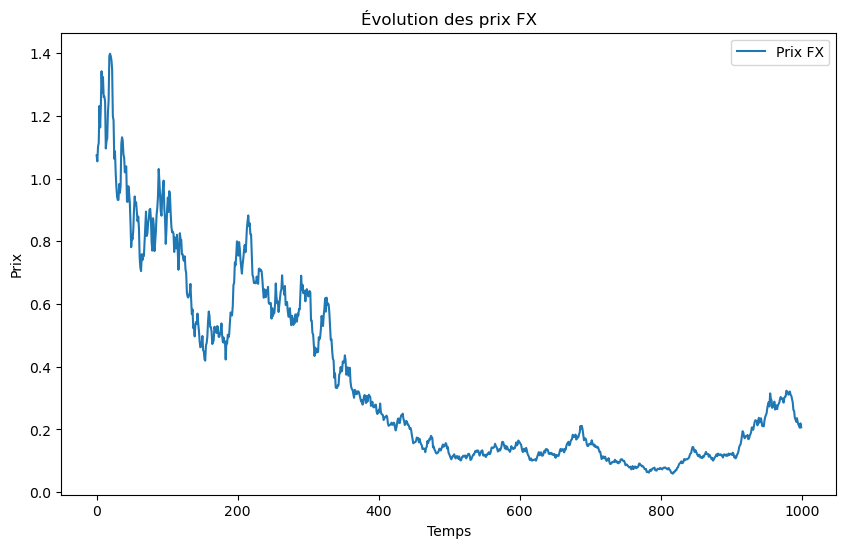

In [212]:
#On affiche le prix du cours FX
plt.figure(figsize=(10, 6))
plt.plot(prix, label="Prix FX")
plt.xlabel("Temps")
plt.ylabel("Prix")
plt.title("Évolution des prix FX")
plt.legend()
plt.show()

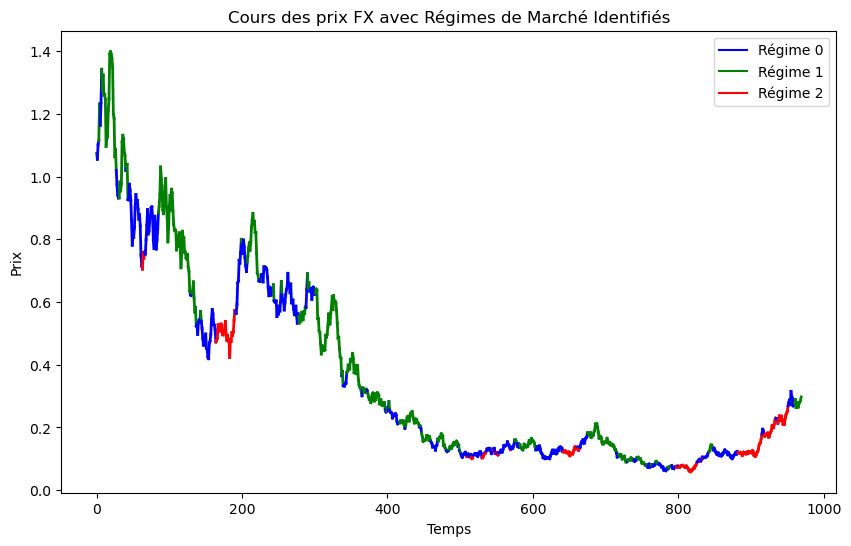

In [213]:
# Visualisation des résultats avec les régimes touvés sur les log_rendements sur les prix FX
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']  # Couleurs pour chaque régime

# Parcourir chaque segment et tracer la série des prix avec la couleur correspondant au régime
for i in range(len(log_returns) - 1):  # len(prix) - 1 car log_returns est basé sur différences entre prix consécutifs
    plt.plot(
        [i, i + 1],  # Segment temporel
        [prix[i], prix[i + 1]],  # Segment des prix
        color=colors[labels[i]],  # Couleur correspondant au régime
        linewidth=2
    )

plt.xlabel("Temps")
plt.ylabel("Prix")
plt.title("Cours des prix FX avec Régimes de Marché Identifiés")
# Ajouter une légende
for i, color in enumerate(colors):
    plt.plot([], [], color=color, label=f"Régime {i}")
plt.legend()
plt.show()

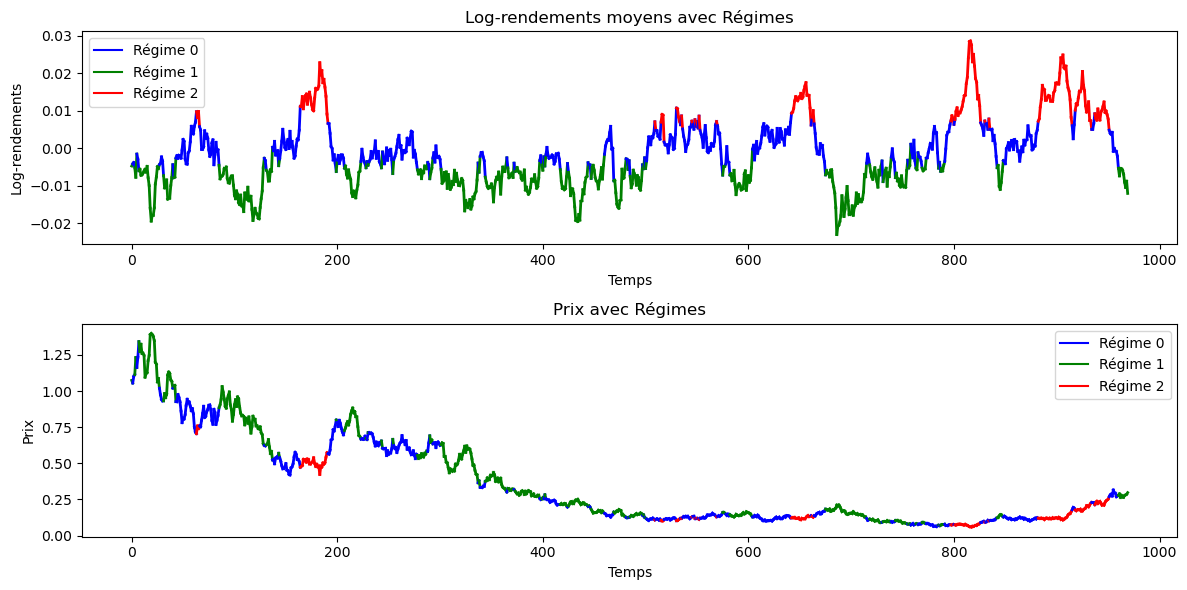

In [214]:
#On affiche ici les régimes sur le cours des prix FX et sur les log-rendements pour voir s'ils s'appliquent bien

# Graphique 1 : Log-rendements avec les régimes
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)  # Premier sous-graphe
for i in range(len(log_returns) - 1):
    plt.plot(
        [i, i + 1],
        [log_returns[i], log_returns[i + 1]],
        color=colors[labels[i]],
        linewidth=2
    )
plt.title("Log-rendements moyens avec Régimes")
plt.xlabel("Temps")
plt.ylabel("Log-rendements")
for i, color in enumerate(colors):
    plt.plot([], [], color=color, label=f"Régime {i}")
plt.legend()

# Graphique 2 : Prix avec les régimes
plt.subplot(2, 1, 2)  # Deuxième sous-graphe
for i in range(len(log_returns) - 1):
    plt.plot(
        [i, i + 1],
        [prix[i], prix[i + 1]],
        color=colors[labels[i]],
        linewidth=2
    )
plt.title("Prix avec Régimes")
plt.xlabel("Temps")
plt.ylabel("Prix")
for i, color in enumerate(colors):
    plt.plot([], [], color=color, label=f"Régime {i}")
plt.legend()

plt.tight_layout()
plt.show()


On voit ici que la couleur du sommet des log rendements représente un régime haussier, celle au milieu est un régime dit stable ou neutre et la dernière correspond au régime baissier.

Backtest with Merton Jump Diffusion

first let's create our syntethic data using merton jump diffusion model. We choose her to implement it by our own without any package to understand the meths behind it. We set here 1/1000 (to be coherent with our others test) but we can change this parameter, like all the others depending on the output we want. We choose an arbitrary starting price of 100 for our price.

In [218]:
def simulate_merton_jump_diffusion(T=1, dt=1/1000, S0=100, mu=0.1, sigma=0.2, lambda_jump=0.5, mu_jump=0, sigma_jump=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    N = int(T / dt)
    S = np.zeros(N + 1)
    S[0] = S0
    for t in range(1, N + 1):
        dW = np.random.normal(0, np.sqrt(dt))
        dN = np.random.poisson(lambda_jump * dt)
        jump_sum = 0
        if dN > 0:
            jump_sum = np.sum(np.random.normal(mu_jump, sigma_jump, dN))
        S[t] = S[t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW + jump_sum)
    
    return S

We then implement a function that backtests a trading strategy by adjusting portfolio exposure based on market regimes. It simulates portfolio growth, visualizes price and returns with regimes, and calculates performance metrics like total return, Sharpe ratio, and max drawdown. It is a really basic trading strategy, but we are going to enhance it in the futur. 

In [220]:
def backtest_regime_strategy(log_returns, prix, labels, window=30, initial_capital=10000):
    portfolio_values = [initial_capital]
    regime_actions = {0: -0.5, 1: 0.0, 2: 0.5}
    adjusted_labels = np.repeat(labels, window)[:len(log_returns)]
    
    for i in range(len(log_returns)):
        regime_weight = regime_actions.get(adjusted_labels[i], 0)
        portfolio_return = regime_weight * log_returns[i]
        new_value = portfolio_values[-1] * np.exp(portfolio_return)
        portfolio_values.append(new_value)
    
    portfolio_values = np.array(portfolio_values)
    returns = np.diff(portfolio_values) / portfolio_values[:-1]
    
    # Visualization
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.title('Portfolio Value over Time using merton jump diffusion model for data')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    
    plt.subplot(3, 1, 2)
    colors = ['blue', 'green', 'red']
    for i in range(len(prix) - 1):
        plt.plot([i, i + 1], [prix[i], prix[i + 1]], color=colors[adjusted_labels[i]], linewidth=2)
    plt.title('Price with Market Regimes using merton jump diffusion model for data')
    plt.xlabel('Time')
    plt.ylabel('Price')
    
    plt.subplot(3, 1, 3)
    for i in range(len(log_returns) - 1):
        plt.plot([i, i + 1], [log_returns[i], log_returns[i + 1]], color=colors[adjusted_labels[i]], linewidth=2)
    plt.title('Log Returns with Market Regimes using merton jump diffusion model for data')
    plt.xlabel('Time')
    plt.ylabel('Log Returns')
    
    plt.tight_layout()
    plt.show()
    
    total_return = (portfolio_values[-1] - portfolio_values[0]) / portfolio_values[0]
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)
    max_drawdown = np.max(np.maximum.accumulate(portfolio_values) - portfolio_values) / np.max(portfolio_values)
    
    return {
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'portfolio_values': portfolio_values
    }

then we create a backtest function that implement everything together, reusing the WassersteinKMeans function defined at the beginning of the notebook

In [222]:
def regime_detection_backtest(window=30, n_clusters=3, seed=42):
    prix = simulate_merton_jump_diffusion(seed=seed)
    log_returns = np.diff(np.log(prix))
    windowed_log_returns = np.array([
        np.mean(log_returns[i:i + window]) for i in range(len(log_returns) - window + 1)
    ])

    wasserstein_kmeans = WassersteinKMeans(n_clusters=3)
    labels = wasserstein_kmeans.fit(log_returns.reshape(-1, 1))
    performance = backtest_regime_strategy(log_returns, prix, labels, window)
    return performance

Now we can run it 

C:\Apps\ANACONDA\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


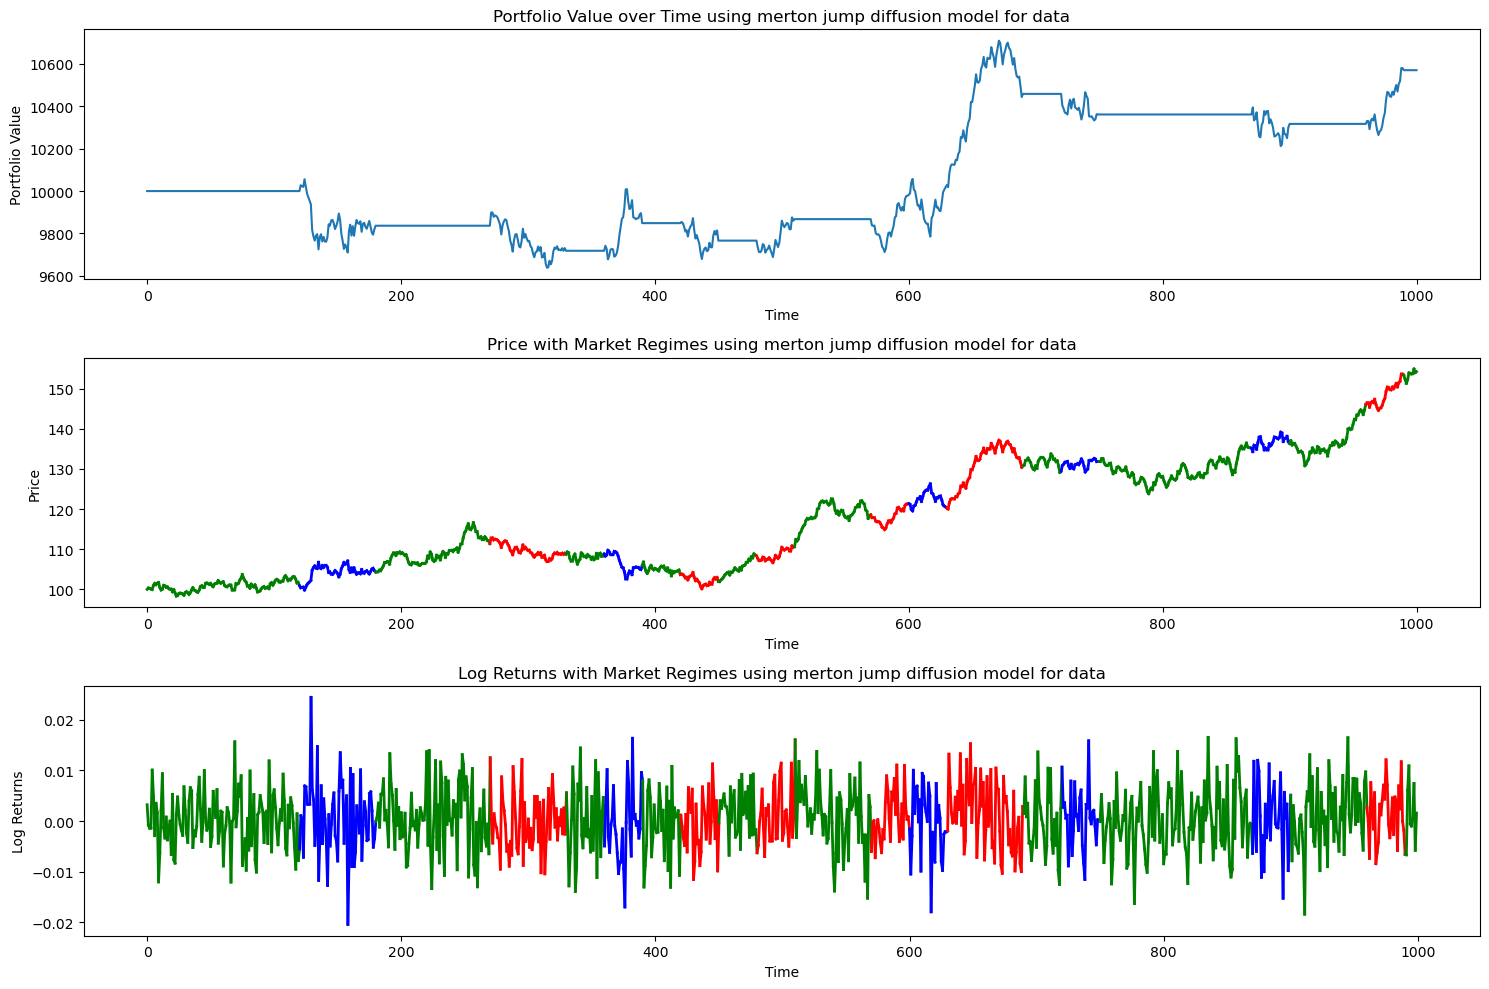

Backtest Performance Metrics:
total_return: 0.05703852135763427
sharpe_ratio: 0.4508732000952037
max_drawdown: 0.046446889756703295


In [224]:
results = regime_detection_backtest()
print("Backtest Performance Metrics:")
for metric, value in results.items():
    if metric != 'portfolio_values':
        print(f"{metric}: {value}")